In [1]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import OmicsIntegrator as oi
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools
import network_utils as nu

In [2]:
# Reload modules in case of modifications
reload(nu)

<module 'network_utils' from '/home/louiscam/projects/gpcr/code/analysis_mar10/network_utils.py'>

# Data directories

In [3]:
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'

# Adhesome components

In [4]:
# Load components
components_filename = 'components.csv'
df_components = pd.read_csv(dir_adhesome+components_filename, sep = ',', header = 0)
print('Number of components: '+str(len(df_components)))
print('Number of intrinsic components: '+str(len(df_components[df_components['FA']=='Intrinsic Proteins'])))
print('Number of associated components: '+str(len(df_components[df_components['FA']=='Associated Proteins'])))
df_components.head()

Number of components: 232
Number of intrinsic components: 150
Number of associated components: 82


,Official Symbol,Gene ID,Protein name,Swiss-Prot ID,Synonyms,Functional Category,FA
0,ACTN1,87,Actinin,P12814,alpha-actinin,Actin regulation,Intrinsic Proteins
1,CFL1,1072,cofilin,P23528,CFL,Actin regulation,Intrinsic Proteins
2,CORO1B,57175,coronin 1B,Q9BR76,coronin-2,Actin regulation,Intrinsic Proteins
3,CTTN,2017,Cortactin,Q14247,"EMS1, Amplaxin",Actin regulation,Intrinsic Proteins
4,FLNA,2316,Filamin,P21333,"endothelial actin-binding protein, ABP-280, al...",Actin regulation,Intrinsic Proteins


# Adhesome interactions

In [6]:
# Load interactions
interactions_filename = 'interactions.csv'
df_interactions = pd.read_csv(dir_adhesome+interactions_filename, sep = ',', header = 0)
print('Number of interactions: '+str(len(df_interactions)))
df_interactions.head()

Number of interactions: 6542


,Source,Target,Effect,Type,PMID,data_source
0,LPXN,GIT1,0,Binding,12674328,adhesome.org
1,GIT1,ARF1,_,Inhibition,10896954,adhesome.org
2,ARPC2,CTTN,0,Binding,11018051,adhesome.org
3,INSR,PTPN6,+,Activation,7512963,adhesome.org
4,ACTB,TLN1,0,Binding,2121138,adhesome.org


In [24]:
# Remove duplicates based on Source, Target, Effect, Type
df_interactions = df_interactions.sort_values(by='data_source')
df_interactions = df_interactions.drop_duplicates(subset=['Source','Target','Effect','Type'], keep='first')
print('Number of interactions: '+str(len(df_interactions)))

Number of interactions: 3637


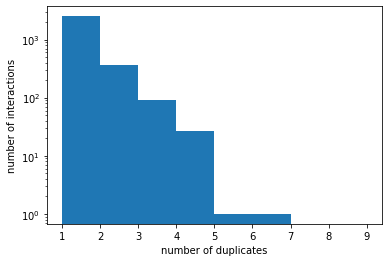

In [25]:
# Count duplicates
duplicate_counts = df_interactions.groupby(['Source','Target'],as_index=False).size().tolist()
plt.figure()
plt.hist(duplicate_counts,range(1,10))
plt.xlabel('number of duplicates')
plt.ylabel('number of interactions')
plt.yscale('log')
plt.show()

In [26]:
# Measure the number of contradictory information
df_interactions1 = df_interactions.drop_duplicates(subset=['Source','Target','Effect'], keep='first')
df_interactions1 = df_interactions1[df_interactions1['Effect']!='0']
# Display duplicates
dup = df_interactions1.loc[df_interactions1.duplicated(subset=['Source','Target'],keep=False),:].sort_values(by=['Source','Target'])
dup.head()

,Source,Target,Effect,Type,PMID,data_source
11,ABL1,CBL,_,Inhibition,12475393,adhesome.org
8,ABL1,CBL,+,Activation,7925293,adhesome.org
1049,CAPN1,PRKCA,_,Inhibition,8070569,adhesome.org
1050,CAPN1,PRKCA,+,Activation,11950589,adhesome.org
189,CBL,ABL1,_,Inhibition,12475393,adhesome.org


### Order effect by +, -, 0

In [27]:
# Set category with ordering
df_interactions['Effect'] = df_interactions['Effect'].astype('category')
df_interactions['Effect'] = df_interactions['Effect'].cat.set_categories(['+', '_', '0'], ordered=True)

### Order type with activation and inhibition on top

In [28]:
# Harmonize types
df_interactions['Type'] = df_interactions['Type'].str.lower().str.replace('_reaction','')
np.unique(df_interactions['Type'])
# Set category with ordering
type_order = np.array(['activation','inhibition','gef','enzymatic','compound','direct_interaction','colocalization',
                       'binding','dephosphorylation','phosphorylation','unknown'])
df_interactions['Type'] = df_interactions['Type'].astype('category')
df_interactions['Type'] = df_interactions['Type'].cat.set_categories(type_order, ordered=True)

### Discard duplicates

In [29]:
# Only keep non-0 effect interactions, drop all duplicates
df_interactions = df_interactions[df_interactions['Effect']!='0']
df_interactions = df_interactions.drop_duplicates(subset=['Source','Target'], keep=False)
df_interactions = df_interactions.drop_duplicates(subset=['PMID'], keep='first')
df_interactions.head()

,Source,Target,Effect,Type,PMID,data_source
918,CSK,IRS1,+,activation,8756634,adhesome.org
917,ACTN1,PTPN1,_,inhibition,16291744,adhesome.org
915,PTK2B,PTPN11,_,inhibition,10880513,adhesome.org
914,ARF1,PLD1,+,activation,16054594,adhesome.org
913,DNM2,PLD1,_,inhibition,16622417,adhesome.org


# Construct adhesome network

In [39]:
# Create networkX adhesome network without node attributes (create_using=nx.DiGraph())
adhesome_network = nx.from_pandas_edgelist(df_interactions, 'Source', 'Target', 
                                           ['Effect', 'Type', 'PMID', 'data_source'])
print('Number of nodes = '+str(len(adhesome_network.nodes)))

Number of nodes = 117


In [40]:
# Dictionary of node attributes
node_attributes = {
    df_components['Official Symbol'][i]: {'Gene ID': df_components['Gene ID'][i],
                                         'Protein name': df_components['Protein name'][i],
                                         'Swiss-Prot ID': df_components['Swiss-Prot ID'][i],
                                         'Synonyms': df_components['Synonyms'][i],
                                         'Functional Category': df_components['Functional Category'][i],
                                         'FA': df_components['FA'][i]
                                                        } 
                   for i in range(len(df_components))

}

In [41]:
# Add node attributes to networkx graph
nx.set_node_attributes(adhesome_network, node_attributes)

In [42]:
# Safety check
print(nx.get_node_attributes(adhesome_network, 'FA')['CTTN'])
print(nx.get_edge_attributes(adhesome_network, 'Type')[('CSK', 'IRS1')])

Intrinsic Proteins
activation


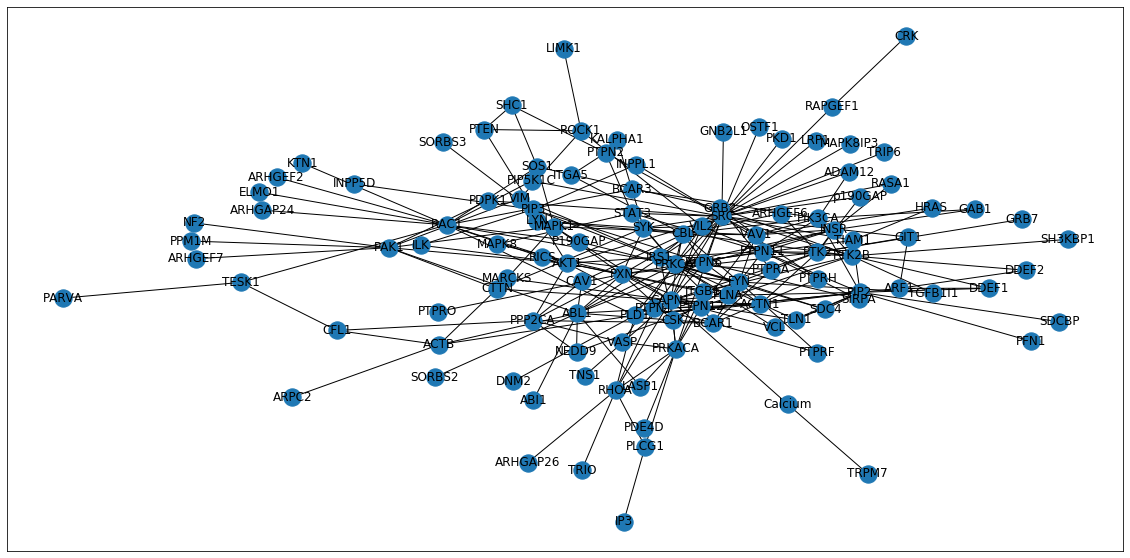

In [43]:
# Plot adhesome network
plt.figure(figsize = (20,10))
nx.draw_networkx(adhesome_network, pos=None, arrows=True, with_labels=True)
plt.show()

# Cluster the network

In [44]:
# First test whether there is a community structure in this network
A = np.array(nx.adjacency_matrix(adhesome_network).todense())
nu.PET_test(A,0.05)

{'test_stat': 1246.8373819787685,
 'p_val': 1.7893800373337907e-271,
 'reject': True}

In [45]:
# Network connected?
nx.is_connected(adhesome_network.to_undirected())

True

In [46]:
# Use undirected network
adhesome_network_undi = adhesome_network

In [47]:
# Cluster network using Louvain community detection
partition_adhesome = community.best_partition(adhesome_network_undi, resolution=1,random_state=13)
print('Number of communities = '+str(len(set(partition_adhesome.values()))))
print('Modularity = '+str(community.modularity(partition_adhesome,adhesome_network_undi)))

Number of communities = 9
Modularity = 0.41892192187425603


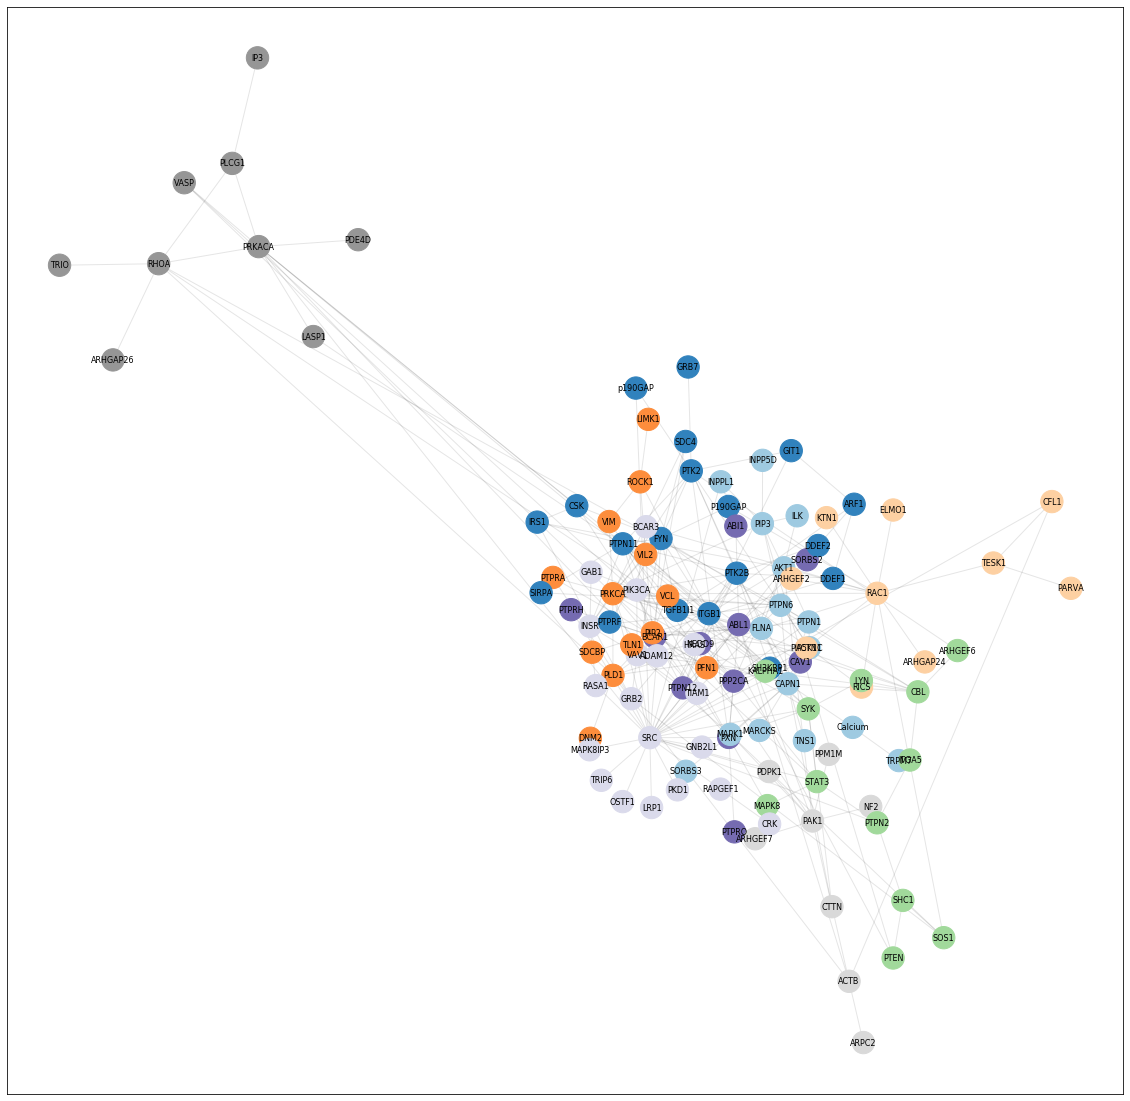

In [48]:
# Drawing
reload(nu)
plt.figure(figsize = (20,20))
size = float(len(set(partition_adhesome.values())))
pos = nu.community_layout(adhesome_network_undi, partition_adhesome)
nx.draw_networkx_nodes(adhesome_network_undi, pos, node_size=500, cmap=plt.cm.tab20c, node_color=list(partition_adhesome.values()))
nx.draw_networkx_edges(adhesome_network_undi, pos, alpha=0.1)
nx.draw_networkx_labels(adhesome_network_undi, pos, font_size=8,font_family='sans-serif')
plt.show()

# Identify enrichment for activation/inhibition edges

In [54]:
# Edge types in network
nx.to_pandas_edgelist(adhesome_network).Effect.value_counts()

+    168
_     83
Name: Effect, dtype: int64

In [49]:
# Number of communities
n_comm = len(set(partition_adhesome.values()))

In [50]:
comm1 = [prot for prot in partition_adhesome.keys() if partition_adhesome[prot]==0 ]

In [51]:
sub1 = adhesome_network.subgraph(comm1)

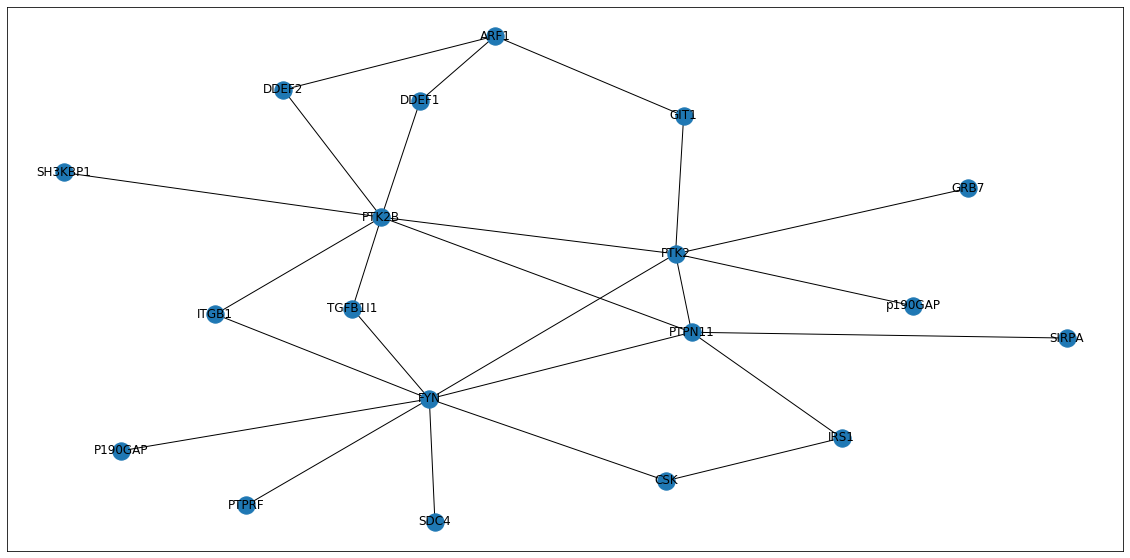

In [52]:
plt.figure(figsize = (20,10))
nx.draw_networkx(sub1, pos=None, arrows=True, with_labels=True)
plt.show()

In [55]:
nx.to_pandas_edgelist(sub1).Effect.value_counts()

+    17
_     8
Name: Effect, dtype: int64